# Site: https://ranked.vote/us/vt/btv/2009/03/mayor/

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_6dd29cb37a5a4229aa0369766e115816 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='FMiQxxbvcxsFnOD6gzISALhMwFwqo3aM-A75d1XV_pJl',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_6dd29cb37a5a4229aa0369766e115816.get_object(Bucket='rcvproject-donotdelete-pr-648lfgyjpvv139',Key='us_vt_btv_2009_03_mayor.normalized (1).csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,ballot_id,rank,choice
0,000001-00-0001,1,Bob Kiss
1,000001-00-0001,2,Andy Montroll
2,000001-00-0006,1,Bob Kiss
3,000001-00-0006,2,Andy Montroll
4,000001-00-0008,1,Bob Kiss


In [2]:
len(df)

28703

Special exceptions, from https://github.com/ranked-vote/rcv-data-format/blob/master/README.md#normalized-vs-raw:

- UNDERVOTE: the ballot did not list a candidate for this rank.
- OVERVOTE: the ballot voted for multiple candidates in the rank, invalidating the vote for that rank (and possibly others, depending on the jurisdiction’s rules.)
- WRITE_IN: the ballot listed a write-in candidate, and the raw voting data does not indicate that candidate’s name.

# 2019 RCV Python library: https://pypi.org/project/pyrankvote/
# repo here: https://github.com/jontingvold/pyrankvote

In [4]:
# !pip install pyrankvote

In [5]:
import pyrankvote
from pyrankvote import Candidate, Ballot

kiss = Candidate('Bob Kiss')
montroll = Candidate('Andy Montroll')
wright = Candidate('Kurt Wright')
smith = Candidate('Dan Smith')
simpson = Candidate('James Simpson')

In [6]:
candidates = [kiss, montroll, wright, smith, simpson]

In [7]:
df.head()

,ballot_id,rank,choice
0,000001-00-0001,1,Bob Kiss
1,000001-00-0001,2,Andy Montroll
2,000001-00-0006,1,Bob Kiss
3,000001-00-0006,2,Andy Montroll
4,000001-00-0008,1,Bob Kiss


In [8]:
df1 = df.pivot(index='ballot_id', columns='rank', values='choice').rename_axis(None, axis=1).reset_index()

In [9]:
df1.head()

,ballot_id,1,2,3,4,5
0,000001-00-0001,Bob Kiss,Andy Montroll,NaN,NaN,NaN
1,000001-00-0002,Andy Montroll,NaN,NaN,NaN,NaN
2,000001-00-0003,Andy Montroll,Bob Kiss,Kurt Wright,NaN,NaN
3,000001-00-0004,Andy Montroll,Kurt Wright,NaN,NaN,NaN
4,000001-00-0005,Kurt Wright,NaN,NaN,NaN,NaN


In [10]:
import numpy as np

df1 = df1.replace(np.nan, '0')

In [11]:
df1.dtypes

ballot_id    object
1            object
2            object
3            object
4            object
5            object
dtype: object

In [12]:
list_of_ballot_choices = df1[[1, 2, 3, 4, 5]].values.tolist()

In [13]:
list_of_ballot_choices[:10]

[['Bob Kiss', 'Andy Montroll', '0', '0', '0'],
 ['Andy Montroll', '0', '0', '0', '0'],
 ['Andy Montroll', 'Bob Kiss', 'Kurt Wright', '0', '0'],
 ['Andy Montroll', 'Kurt Wright', '0', '0', '0'],
 ['Kurt Wright', '0', '0', '0', '0'],
 ['Bob Kiss', 'Andy Montroll', '0', '0', '0'],
 ['Kurt Wright', '0', '0', '0', '0'],
 ['Bob Kiss', 'Dan Smith', 'Andy Montroll', 'Kurt Wright', 'James Simpson'],
 ['Bob Kiss', 'James Simpson', 'Andy Montroll', '0', '0'],
 ['Kurt Wright', '0', '0', '0', '0']]

In [14]:
for x in list_of_ballot_choices:
    while '0' in x:
        x.remove('0')

In [15]:
list_of_ballot_choices

[['Bob Kiss', 'Andy Montroll'],
 ['Andy Montroll'],
 ['Andy Montroll', 'Bob Kiss', 'Kurt Wright'],
 ['Andy Montroll', 'Kurt Wright'],
 ['Kurt Wright'],
 ['Bob Kiss', 'Andy Montroll'],
 ['Kurt Wright'],
 ['Bob Kiss', 'Dan Smith', 'Andy Montroll', 'Kurt Wright', 'James Simpson'],
 ['Bob Kiss', 'James Simpson', 'Andy Montroll'],
 ['Kurt Wright'],
 ['Dan Smith', 'Bob Kiss'],
 ['Kurt Wright'],
 ['Bob Kiss', 'Dan Smith'],
 ['Write-in', 'Andy Montroll', 'Bob Kiss', 'Dan Smith', 'James Simpson'],
 ['Bob Kiss', 'Andy Montroll', 'Dan Smith', 'Kurt Wright', 'James Simpson'],
 ['Bob Kiss', 'Andy Montroll'],
 ['Bob Kiss', 'Andy Montroll', 'Kurt Wright', 'Dan Smith', 'James Simpson'],
 ['Andy Montroll', 'Bob Kiss', 'Kurt Wright'],
 ['Dan Smith', 'Andy Montroll', 'Kurt Wright', 'Bob Kiss'],
 ['Bob Kiss', 'Andy Montroll'],
 ['Bob Kiss', 'Andy Montroll'],
 ['Bob Kiss', 'Andy Montroll', 'Dan Smith'],
 ['Bob Kiss', 'Andy Montroll', 'Dan Smith', 'Kurt Wright', 'James Simpson'],
 ['Bob Kiss', 'Kurt Wright'

In [16]:
df1['ballot_choices_list'] = list_of_ballot_choices

In [17]:
def remove_anomalies_from_ballots(ballots, value_to_remove):
    """
    ballots: series from dataframe. Each row contains a list of ranked candidates representing 1 ballot.
    value_to_remove: string that a ballot contains as a condition for its deletion
    """
    indices_to_drop = []
    
    for index, value in enumerate(ballots):
        if value_to_remove in value:
            indices_to_drop.append(index)
                   
    return indices_to_drop


In [18]:
# Removing write-ins, undervotes, and overvotes

write_in_indices_to_drop = remove_anomalies_from_ballots(df1['ballot_choices_list'], 'Write-in')

In [19]:
undervote_indices_to_drop = remove_anomalies_from_ballots(df1['ballot_choices_list'], '$UNDERVOTE')

In [20]:
undervote_indices_to_drop

[725, 727, 728, 3668, 6861]

In [21]:
overvote_indices_to_drop = remove_anomalies_from_ballots(df1['ballot_choices_list'], '$OVERVOTE')

In [22]:
overvote_indices_to_drop

[725, 727, 728, 3668, 4265, 6861]

In [23]:
indices_to_drop = write_in_indices_to_drop +  undervote_indices_to_drop + overvote_indices_to_drop

In [24]:
df1 = df1.drop(index=indices_to_drop)

---

In [104]:
test = df1['ballot_choices_list'].apply(lambda x: ", ".join(x))

In [106]:
len(set(test.to_list()))

254

In [147]:
test_2 = pd.DataFrame(df1['ballot_choices_list'].apply(lambda x: ", ".join(x)))

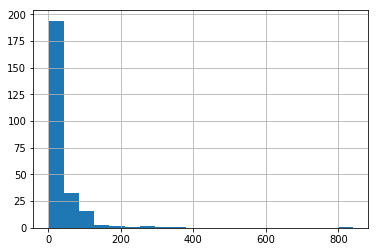

In [153]:
test_2['ballot_choices_list'].value_counts().hist(bins=20) # ballots in Burlington election are NOT normally distributed

---

In [25]:
candidates_array = []

for candidate_list in df1['ballot_choices_list']:
    ballot = []
    for candidate in candidate_list:
        candidate = candidate.strip(' ')
        ballot.append(Candidate(candidate))
    candidates_array.append(ballot)

In [26]:
df1['ballot_choices_list_with_candidate_objects'] = candidates_array

In [27]:
df1.head()

,ballot_id,1,2,3,4,5,ballot_choices_list,ballot_choices_list_with_candidate_objects
0,000001-00-0001,Bob Kiss,Andy Montroll,0,0,0,"[Bob Kiss, Andy Montroll]","[Bob Kiss, Andy Montroll]"
1,000001-00-0002,Andy Montroll,0,0,0,0,[Andy Montroll],[Andy Montroll]
2,000001-00-0003,Andy Montroll,Bob Kiss,Kurt Wright,0,0,"[Andy Montroll, Bob Kiss, Kurt Wright]","[Andy Montroll, Bob Kiss, Kurt Wright]"
3,000001-00-0004,Andy Montroll,Kurt Wright,0,0,0,"[Andy Montroll, Kurt Wright]","[Andy Montroll, Kurt Wright]"
4,000001-00-0005,Kurt Wright,0,0,0,0,[Kurt Wright],[Kurt Wright]


In [28]:
len(df1)

8735

In [66]:
ballot_objects = []

for index,value in enumerate(df1['ballot_choices_list_with_candidate_objects']):
    ballot = Ballot(ranked_candidates=value)
    ballot_objects.append(ballot)

DuplicateCandidatesError: 

In [67]:
df1['ballot_objects'] = ballot_objects

ValueError: Length of values does not match length of index

In [34]:
df1.head()

,ballot_id,1,2,3,4,5,ballot_choices_list,ballot_choices_list_with_candidate_objects,ballot_objects
0,000001-00-0001,Bob Kiss,Andy Montroll,0,0,0,"[Bob Kiss, Andy Montroll]","[Bob Kiss, Andy Montroll]","<Ballot(Bob Kiss, Andy Montroll)>"
1,000001-00-0002,Andy Montroll,0,0,0,0,[Andy Montroll],[Andy Montroll],<Ballot(Andy Montroll)>
2,000001-00-0003,Andy Montroll,Bob Kiss,Kurt Wright,0,0,"[Andy Montroll, Bob Kiss, Kurt Wright]","[Andy Montroll, Bob Kiss, Kurt Wright]","<Ballot(Andy Montroll, Bob Kiss, Kurt Wright)>"
3,000001-00-0004,Andy Montroll,Kurt Wright,0,0,0,"[Andy Montroll, Kurt Wright]","[Andy Montroll, Kurt Wright]","<Ballot(Andy Montroll, Kurt Wright)>"
4,000001-00-0005,Kurt Wright,0,0,0,0,[Kurt Wright],[Kurt Wright],<Ballot(Kurt Wright)>


In [35]:
candidates

[<Candidate('Bob Kiss')>,
 <Candidate('Andy Montroll')>,
 <Candidate('Kurt Wright')>,
 <Candidate('Dan Smith')>,
 <Candidate('James Simpson')>]

In [44]:
df1['ballot_objects'].loc[0]

<Ballot(Bob Kiss, Andy Montroll)>

In [36]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.

from project_lib import Project
project = Project(project_id='1daf31ed-7906-4de8-ba86-1426ab880329', project_access_token='p-07aa6e741e360e357f73a6d886ba08a49d808259')
pc = project.project_context


In [37]:
# project.save_data(file_name = "test_2.csv",data=df1.to_csv(index=False))


In [38]:
election_result = pyrankvote.instant_runoff_voting(candidates, df1['ballot_objects'])


In [39]:
election_result

ElectionResults(5 rounds)

In [40]:
print(election_result)

ROUND 1
Candidate        Votes  Status
-------------  -------  --------
Kurt Wright       2905  Hopeful
Bob Kiss          2514  Hopeful
Andy Montroll     2016  Hopeful
Dan Smith         1269  Hopeful
James Simpson       31  Hopeful

ROUND 2
Candidate        Votes  Status
-------------  -------  --------
Kurt Wright       2910  Hopeful
Bob Kiss          2527  Hopeful
Andy Montroll     2020  Hopeful
Dan Smith         1278  Hopeful
James Simpson        0  Rejected

ROUND 3
Candidate        Votes  Status
-------------  -------  --------
Kurt Wright       3283  Hopeful
Bob Kiss          2937  Hopeful
Andy Montroll     2515  Hopeful
Dan Smith            0  Rejected
James Simpson        0  Rejected

ROUND 4
Candidate        Votes  Status
-------------  -------  --------
Bob Kiss          4467  Hopeful
Kurt Wright       4268  Hopeful
Andy Montroll        0  Rejected
Dan Smith            0  Rejected
James Simpson        0  Rejected

FINAL RESULT
Candidate        Votes  Status
-------------  ---

In [41]:
winners = election_result.get_winners()

In [42]:
winners

[<Candidate('Bob Kiss')>]

In [ ]:
# Bob Kiss won after three runoff rounds, while Andy Montroll was the Condorcet winner.  - https://ranked.vote/us/vt/btv/2009/03/mayor/

In [43]:
candidate_names=[]
for cand in candidates:
    candidate_names.append(cand.name)
    
print("candidate_names: ",candidate_names)
cand_matrix= pd.DataFrame(0, columns=candidate_names, index=candidate_names)
cand_matrix

candidate_names:  ['Bob Kiss', 'Andy Montroll', 'Kurt Wright', 'Dan Smith', 'James Simpson']


,Bob Kiss,Andy Montroll,Kurt Wright,Dan Smith,James Simpson
Bob Kiss,0,0,0,0,0
Andy Montroll,0,0,0,0,0
Kurt Wright,0,0,0,0,0
Dan Smith,0,0,0,0,0
James Simpson,0,0,0,0,0


In [42]:
all_ballots = list(df1['ballot_objects'].values)
ballot_dict={}
for i in range(len(all_ballots)):
    ballot_str=str(all_ballots[i])
    curr_ballot = all_ballots[i]
    if ballot_str in ballot_dict:
        ballot_dict[ballot_str][0]=ballot_dict[ballot_str][0]+1
    else:
        ballot_dict[ballot_str]=[1,all_ballots[i]]


In [43]:
for ballot in ballot_dict:
    #print(ballot_dict[ballot])
    ranked_candidates = list(ballot_dict[ballot][1].ranked_candidates)
    #print(ranked_candidates, type(ranked_candidates))
    for i in range(len(ranked_candidates)):
        for j in range(len(ranked_candidates)):
            #print("i=",i, " j=", j,ranked_candidates[i].name, ranked_candidates[j].name)
            if (ranked_candidates[i].name!=ranked_candidates[j].name) & (i<j):
                cand_matrix[ranked_candidates[j].name][ranked_candidates[i].name] = cand_matrix[ranked_candidates[j].name][ranked_candidates[i].name]+ballot_dict[ballot][0]


[355, <Ballot(Bob Kiss, Andy Montroll)>]
[178, <Ballot(Andy Montroll)>]
[46, <Ballot(Andy Montroll, Bob Kiss, Kurt Wright)>]
[94, <Ballot(Andy Montroll, Kurt Wright)>]
[840, <Ballot(Kurt Wright)>]
[55, <Ballot(Bob Kiss, Dan Smith, Andy Montroll, Kurt Wright, James Simpson)>]
[16, <Ballot(Bob Kiss, James Simpson, Andy Montroll)>]
[51, <Ballot(Dan Smith, Bob Kiss)>]
[125, <Ballot(Bob Kiss, Dan Smith)>]
[123, <Ballot(Bob Kiss, Andy Montroll, Dan Smith, Kurt Wright, James Simpson)>]
[71, <Ballot(Bob Kiss, Andy Montroll, Kurt Wright, Dan Smith, James Simpson)>]
[27, <Ballot(Dan Smith, Andy Montroll, Kurt Wright, Bob Kiss)>]
[234, <Ballot(Bob Kiss, Andy Montroll, Dan Smith)>]
[15, <Ballot(Bob Kiss, Kurt Wright, Dan Smith, Andy Montroll)>]
[16, <Ballot(Dan Smith, Bob Kiss, Kurt Wright, Andy Montroll, James Simpson)>]
[200, <Ballot(Andy Montroll, Bob Kiss)>]
[41, <Ballot(Andy Montroll, Dan Smith, Bob Kiss, Kurt Wright)>]
[88, <Ballot(Dan Smith, Bob Kiss, Andy Montroll)>]
[93, <Ballot(Andy Mont

In [44]:
cand_matrix1 = cand_matrix.copy(deep=True)
for i in cand_matrix1.columns:
    for j in cand_matrix1.index:
        cand_matrix1[i][j] = cand_matrix[i][j] - cand_matrix[j][i]

In [45]:
cand_matrix1

,Bob Kiss,Andy Montroll,Kurt Wright,Dan Smith,James Simpson
Bob Kiss,0,-85,143,253,1809
Andy Montroll,85,0,310,967,2300
Kurt Wright,-143,-310,0,185,1246
Dan Smith,-253,-967,-185,0,2073
James Simpson,-1809,-2300,-1246,-2073,0
